# Introduction to Molecular Dynamics Simulation with Python

<img src="images/MD_rotor_250K_1ns.gif" width=250/>
            
<p style="text-align: center;"> Rotation of a supramolecule inside a nanopore on silver surface. Source: wikipedia  </p>

This tutorial has been adapted form Jacob Maritn's [blogspot](https://nznano.blogspot.com/2017/11/molecular-dynamics-in-python.html).

## What is MD?

- Molecular dynamics (MD) is a computer simulation method for analyzing the physical movements of atoms and molecules. The atoms and molecules are allowed to interact for a fixed period of time, giving a view of the dynamic "evolution" of the system.
- In the most common version, the trajectories of atoms and molecules are determined by numerically solving Newton's equations of motion for a system of interacting particles, where forces between the particles and their potential energies are often calculated using interatomic potentials or molecular mechanics force fields.

- There are many different applications to molecular dynamics including structure optimizations, calculating macroscopic quantities, drug discovery, etc..

Most molecular dynamics programs use classical approximations (Newtonian mechanics) to describe the energy of the system as a function of the positions of the atoms/particles.
$$E(\mathbf{r})$$

**Note**: For simplicity we show the equations in one dimension.

We can use Newton's second law to describe the motion of the particles through time.
$$F = m{a} = m \dfrac {d ^2 {x}}{d t^2}$$

The force can be calculated in one dimension by taking the derivative with respect to $x$ (or in three dimensional vector notation, the gradient $\nabla$) of the potential energy $E(\mathbf{r})$.
$$F = - \dfrac {d E}{d x} = -\nabla E(\mathbf{r})$$

One of the first steps in MD, is to calculate the forces acting on the atoms given a potential and the positions of the atoms.

### MD algorithm

Here's what a simple MD algorithm looks like
<img src="images/MDalgo.png" width=350/>

So let's get started with one of the simplest interatomic potentials out there, the
### Lennard-Jones potential

The potential energy of the 12-6 Lennard-Jones potential is given as:
$$E_{LJ}({r}) = 4\epsilon \left[ \left(\dfrac{\sigma}{r}\right)^{12} - \left(\dfrac{\sigma}{r}\right)^{6} \right]$$
where, $\sigma$ is the radius where the potential is zero and is defined as the van der waals radius. $\epsilon$ is the energy minimum of the interaction (see the figure below).

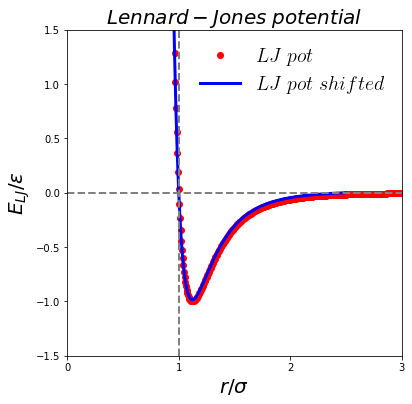

In [1]:
#Import a plotting libraries and a maths library 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

r = np.linspace(0.01,3.0,num=500) # Make a radius vector
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential

plt.figure(figsize=[6,6])
plt.plot(r,E_LJ,'ro',linewidth=1,label=r" $LJ\; pot$") # Red line is unshifted LJ

# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5

plt.plot(r[:415],E_LJ_shift[:415],'b-',linewidth=3,label=r"$LJ\; pot\; shifted$") # Blue line is shifted

#Plot formatting
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.title(r"$Lennard-Jones\; potential$",fontsize=20)
plt.xlim([0.0,3.0])
plt.ylim([-1.5,1.5])
plt.ylabel(r"$E_{LJ}/\epsilon$",fontsize=20)
plt.xlabel(r"$r/\sigma$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.axhline(0, color='grey',linestyle='--',linewidth=2)
plt.axvline(1, color='grey',linestyle='--',linewidth=2)

### Function for Computing the forces
As mentioned above, the forces between particles can be calculated from the derivative/gradient of their potential energy. $F=−\nabla E(r)$

Then, the forces for the LJ potential will be:
$$F_{LJ}({r}) = \epsilon \left[ 48\left(\dfrac{\sigma}{r}\right)^{13} - 24\left(\dfrac{\sigma}{r}\right)^{7} \right]$$

In the function below we compute the forces on a group of atoms located inside a box of given dimension

In [2]:
def Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units
    
    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0
    
    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            Rsijnorm = 1.0 #np.sqrt(Rsqij)
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*Rsijnorm*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial + dphi*np.sqrt(Rsqij) # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient

### Function for computing the temperature
Temperature is a macroscopic quantity. Using the kinetic energy, we can calculate the temperature as:
$$E_K = \dfrac{1}{2}mv^2$$
$$k_B T = \dfrac{2}{\text{DIM}}\sum_N E_K $$

In [3]:
def Calculate_Temperature(vel,BoxSize,DIM,N):
    
    ene_kin = 0.0
    
    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)
    
    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM
    
    return ene_kin_aver,temperature

### Initializing the positions

In [4]:
DIM = 2 # Dimensions
N = 32

BoxSize = 10.0#6.35 

volume  = BoxSize**DIM
density = N / volume
print("volume = ", volume, " density = ", density)

pos = np.zeros([N,DIM])
        
#pos = np.genfromtxt('output.dat',skip_header=1) # Load positions from file
pos = np.array([[1, 3], [5, 4], [4, 8], [1, 6], [1, 4], [5, 8], [4, 4], [8, 7], [3, 8],
 [3, 6], [8, 2], [4, 5], [3, 3], [2, 2], [5, 5],[6,6],[7,7],[8,8],[9,9],[3,7],[2,7],
                [4,6],[2,3],[2,4],[3,4],[3,5],[4,1],[4,2],[5,1],[5,7], [6,1],[6,7]])
#print(len(np.unique(pos, axis=0)))
pos = pos[:,:DIM]/BoxSize
#print(pos)

MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]
    

volume =  100.0  density =  0.32


### Setting up the simulation

In [5]:
NSteps=10000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5#b #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

### A Thermostat
We wish to simulate to hold the atoms at a constant temperature (the system as a thermostat) NPT ensemble!
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/Statistical_Ensembles.png/900px-Statistical_Ensembles.png">

### The main() function for assembly
We will make use of the [velocity Verlet](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) integrator which splits the velocity update into two steps initially doing a half step then modifying the acceleration and then doing the second velocity update. Written in full, this gives:
1. Calculate $x(t+\Delta t)=x(t)+v(t+\dfrac{1}{2})\Delta t$
2. Calculate $v(t+\dfrac{1}{2}\Delta t)=v(t)+\dfrac{1}{2}a(t) \Delta t$
3. Derive $a(t+\Delta t)$ from the interaction potential using $x(t+\Delta t)$
4. Calculate $v(t + \Delta t)=v(t+\dfrac{1}{2})+\dfrac{1}{2}a(t+\Delta t)\Delta t$

**Note**: Between step 1 and 2 we rescale the velocities to maintain the temperature at the requested value.

In [6]:
# Main MD loop
def main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    # Initialize the velocities randomly
    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)

    # Open file which we will save the outputs to
    f = open('io_data/mdtraj.xyz', 'w')
    
    for k in range(NSteps):
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        
        
        # Print output to file every DumpFreq number of steps
        if(k%DumpFreq==0): # The % symbol is the modulus so if the Step is a whole multiple of DumpFreq then print the values

            f.write("%s\n" %(N)) # Write the number of particles to file
            # Write all of the quantities at this step to the file
            f.write("Energy %s, Temperature %.5f\n" %(ene_kin_aver[k]+ene_pot_aver[k],temperature[k]))
            for n in range(N): # Write the positions to file
                f.write("X"+" ")
                for l in range(DIM):
                    f.write(str(pos[n][l]*BoxSize)+" ")
                f.write("\n")
            
            if(DIM==2):
                import matplotlib.pyplot as plt
                from IPython import display
                plt.cla()
                plt.xlim(-0.5*BoxSize,0.5*BoxSize)
                plt.ylim(-0.5*BoxSize,0.5*BoxSize)
                for i in range(N):
                    plt.plot(pos[i,0]*BoxSize,pos[i,1]*BoxSize,'o',markersize=20,)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        #print(ene_kin_aver[k], ene_pot_aver[k], temperature[k], pressure[k]) 

    f.close() # Close the file
    
    return ene_kin_aver, ene_pot_aver, temperature, pressure, pos

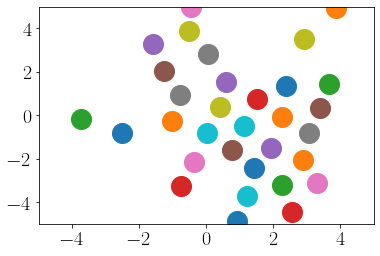

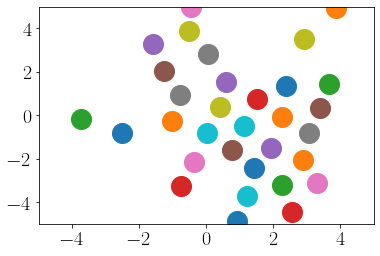

In [7]:
ene_kin_aver, ene_pot_aver, temperature, pressure, pos = main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)

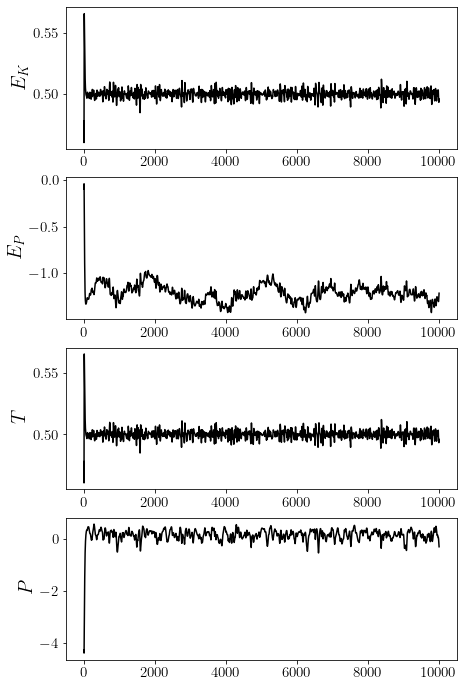

In [8]:
# Plot all of the quantities
def plot():
    plt.figure(figsize=[7,12])
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.subplot(4, 1, 1)
    plt.plot(ene_kin_aver,'k-')
    plt.ylabel(r"$E_{K}$", fontsize=20)
    plt.subplot(4, 1, 2)
    plt.plot(ene_pot_aver,'k-')
    plt.ylabel(r"$E_{P}$", fontsize=20)
    plt.subplot(4, 1, 3)
    plt.plot(temperature,'k-')
    plt.ylabel(r"$T$", fontsize=20)
    plt.subplot(4, 1, 4)
    plt.plot(pressure,'k-')
    plt.ylabel(r"$P$", fontsize=20)
    plt.show()

plot()

In [9]:
print("Temperature = ", np.average(temperature), "+-", 2*np.std(temperature))

Temperature =  0.5000953309761346 +- 0.007833102609907303


In [10]:
print("Pressure = ", np.average(pressure), "+-", 2*np.std(pressure))

Pressure =  0.1411677300607769 +- 0.475439538821898


## Implementation in LAMMPS

### Lennard-Jones melt Argon

[LAMMPS](https://www.lammps.org/) is a very fast molecular dynamics package. 

The input file below performs a much longer simulation in less than a minute. At the top of the this article is the animated video from the simulation where the temperature was reduced from T∗=1.0 to T∗=0.2 showing the nucleation of a crystal.

```
# 2d Lennard-Jones melt

variable    x index 1
variable    y index 1
variable    z index 1

variable    xx equal 40*$x
variable    yy equal 20*$y
variable    zz equal 20*$z

units        lj
atom_style    atomic
dimension 2

lattice        hex 0.8442 #Set the lattice vector
region        box block 0 ${xx} 0 ${yy} 0 1 # Make region for the periodic box
region        two block 5 15 5 15 0 1 # Make a region for where the atoms will begin
create_box    1 box
create_atoms    1 region two # Create the atoms
mass        1 1.0

velocity    all create 1.44 87285 loop geom # Set their initial velocity which will be scaled during the simulation

pair_style    lj/cut 2.5 # Define the intermolecular interaction with the Lennard-Jones function with a cutoff of 2.5
pair_coeff    1 1 1.0 1.0 2.5 # Setting the sigma and epsilon values

# This neighbor list improves the efficiency of the calculation by only calculating interactions with particles within cutoff+0.3
neighbor    0.3 bin 
neigh_modify    delay 0 every 20 check no

dump    1    all xyz 200 io_data/dump.lj #Saves the trajectory to a file to open in VMD
#dump    1    all movie 10000 io_data/movie.gif

fix        1 all nve # Performs an integration to move the sample through time
fix        2 all enforce2d # Make sure there is no forces in the z direction 
fix        3 all temp/rescale 1 1.0 0.2 0.02 0.5 # This rescales the velocity to keep the temperature constant.
run        1000000 #run for this number of steps the default timestep for lj is 0.005 tau 
```

In [11]:
import lammps

In [12]:
lmp = lammps.lammps()

LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task


In [13]:
#lmp.file("io_data/in.lj")



**Here's an accelerated animation of the output of the simulation above**
    <img src="io_data/movie.gif">

### Si elastic constants

In [14]:
#!cat io_data/log.lammps_Si

In [15]:
#!python io_data/compliance.py io_data/log.lammps

## Real world example

Thermal conductivity calculation of Si with point defects (vacancies)

3-body [Stillinger-Weber](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.5262) potential
<img src="images/SW.png">

where $\phi_2$ is a two-body term and $\phi_3$ is a three-body term.

The heat flux in MD can be calculated as
$$\boldsymbol{J} = \frac{1}{\Omega} \frac{d}{dt} \sum_i \boldsymbol{r}_i(t) \epsilon_i(t)$$
where $\Omega$ is the volume of the system and $\epsilon_i$ and ${\bf r}_i$ are the total energy and coordinate vector of atom $i$.

The thermal conductivity is then given as:
$$\kappa_\ell = \frac{1}{k_BVT^2} \int { \langle{\boldsymbol{ J}}(0)\otimes{\boldsymbol{J}(t)\rangle }} dt $$


<img src="images/GK_MD.png">

The effect of vacancies on thermal conductivity of Si

<img src="images/Vac_Kappa_MD.png" width=300>

**Bonny Dongre** et.al.. (10.1088/1361-651X/aa6f57)